In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

from skimage.morphology import label
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime
import pandas as pd

import os
from tqdm import tqdm
import json

Gets the watershed shape files

In [3]:
from skimage import morphology, segmentation

def label_clusters(mat):
    """Sequentially labels distinct clusters in segmentation

    The input can be either a True/False (foreground/background) segmentation,
    or a matrix where every group/cluster shares the same value.
    This will essentially relabel all the clusters starting from 0.
    If a 3D array is passed in it will label each channel separately.

    Args:
        mat (ndarray): 2D/3D array with raw segmentation (or could be labeled)

    Returns:
        ndarray: 2D/3D array with labels for each cluster
    """
    if len(mat.shape) == 3:
        results = np.zeros_like(mat)
        for c in tqdm(range(mat.shape[2])):
            results[:, :, c] = label_clusters(mat[:, :, c])
        return results
    else:
        return morphology.label(mat, connectivity=1, background=-1)


def _label_graph(mat):
    """Labels segments, similar to label_clusters.

    Like label_clusters, this labels each cluster in a segmentation starting from 0.
    This uses a graph, and labels based on connected components.
    It also returns the counts for each component for use to remove small groups.

    Args:
        mat (ndarray): a 2d matrix to label clusters

    Returns:
        tuple: the segmentation map, and the counts for each segment
    """
    seg = label_clusters(mat)
    counts = np.bincount(seg.flatten())
    return seg, counts

def _remove_singletons(seg, min_size, relabel=True):
    """Given a segmentaiton, it removes merges small clusters.

    Any segment smaller than min_size will get merged with the neighbor with the most touching edges.

    Args:
        seg (ndarray): 2d array of labeled segments.

    Returns:
        ndarray: relabeled segmentation with small clusters merged with nearby clusters.
    """
    if relabel:
        seg, counts = _label_graph(seg)
        for i in range(len(counts)):
            if counts[i] < min_size:
                temp = seg == i
                neigh = seg[segmentation.find_boundaries(temp, 2, 'outer')]
                new_lab = np.bincount(neigh).argmax()
                seg[seg == i] = new_lab
        return label_clusters(seg)
    else:
        for i in np.unique(seg):
            temp = seg == i
            if np.sum(temp) < min_size:
                neigh = seg[segmentation.find_boundaries(temp, 2, 'outer')]
                new_lab = np.bincount(neigh).argmax()
                seg[seg == i] = new_lab
        new_lab = 1
        new_seg = seg.copy()
        for i in np.unique(seg):
            new_seg[seg == i] = new_lab
            new_lab += 1
        return new_seg


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

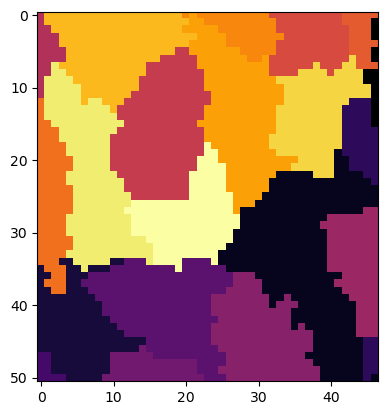

In [4]:
# read in watersheds
shapefile_path = "/home/ScoutJarman/Code/ILWA/data/shapefiles/id_ut8_1601_exp/id_ut8_1601_exp.shp"
watersheds = gpd.read_file(shapefile_path)

# get raster meta data information
raster_path = "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23/ppt19810101.tif"
with rasterio.open(raster_path) as handle:
    raster_arr = handle.read(1)
    meta = handle.meta

# Make segmentations
seg = np.zeros_like(raster_arr)
for idx, geometry in enumerate(watersheds['geometry']):
    mask = geometry_mask([geometry], out_shape=raster_arr.shape, transform=meta['transform'], invert=True)
    seg[mask] = idx + 1

seg = seg.astype(int)
seg = _remove_singletons(seg, 3, False)

plt.imshow(seg, cmap='inferno')
np.unique(seg)

Loop through each ppt file, and aggregate it according to the watersheds

In [ ]:
folders_in = ["/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23",
              "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/tmin_81_23",
              "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/tmax_81_23",
              "/home/ScoutJarman/Code/ILWA/data/rasters/UA/swe_81-23"]
var_names = ['ppt', 'tmin', 'tmax', 'swe']
input_path = "/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif"

with open("/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif.aux.json", 'r') as json_file:
    layer_names = json.load(json_file)['time']
parsed_dates = np.asarray([datetime.strptime(date_str, "%Y-%m-%d") for date_str in layer_names])


In [ ]:
data = []
dates = []
pbar =  tqdm(os.listdir(folders_in[0]))
for file in pbar:
    year = int(file[3:7])
    month = int(file[7:9])
    day = int(file[9:11])
    nums = file[3:-4]
    dtime = datetime(year, month, day)

    try:
        tmp_data = []
        for i, f_in in enumerate(folders_in):
            with rasterio.open(os.path.join(f_in, f"{var_names[i]}{nums}.tif")) as handle:
                raster_arr = handle.read(1)
            for l in np.unique(seg):
                m = np.mean(raster_arr[seg == l])
                tmp_data.append(m)
        data.append(tmp_data)
        dates.append(dtime)
    except:
        pbar.set_description(f"Don't have all variables for {dtime}")
data = np.asarray(data)

In [ ]:
inds = np.argsort(dates)
data_s = data[inds]

# Load in response variables

In [ ]:
csv_path = "/home/ScoutJarman/Code/ILWA/data/other/usgs_data.csv"
df = pd.read_csv(csv_path, parse_dates=['datetime'])
df = df[df['datetime'].isin(dates)]
df = df[['datetime', '309486_00062_00003']]
df = df.rename(columns={'309486_00062_00003': 'Elevation', 'datetime': 'date'})

# column_names = [f"ppt_{i}" for i in np.unique(seg)] + [f"tmean_{i}" for i in np.unique(seg)]
column_names = []
for v_nam in var_names:
    column_names += [f"{v_nam}_{i}" for i in np.unique(seg)]
data_df = pd.DataFrame(data_s, columns=column_names)
df.index = data_df.index

df_daily = pd.concat([df, data_df], axis=1)

df_daily.to_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", index=False)

In [ ]:
plt.plot(df_daily['date'], df_daily['Elevation'])

In [ ]:
print(df_daily.columns)

In [ ]:
plt.plot(df_daily['swe_1'][:2*365])

# LOCA Formatting

In [ ]:
# get raster meta data information
def format_data(max_hist=datetime(2021, 9, 30), min_date=datetime(1981, 10, 1)):
    raster_path = "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23/ppt19810101.tif"
    with rasterio.open(raster_path) as ref_handle:
        for r in ["r1", "r2", "r3"]:
            folders_in = [f"/home/ScoutJarman/Code/ILWA/data/rasters/LOCA/ppt_{r}",
                        f"/home/ScoutJarman/Code/ILWA/data/rasters/LOCA/tmin_{r}",
                        f"/home/ScoutJarman/Code/ILWA/data/rasters/LOCA/tmax_{r}"]
            var_names = ['ppt', 'tmin', 'tmax']
            # Load in variables
            data = []
            dates = []
            pbar =  tqdm(os.listdir(folders_in[0]))
            for file in pbar:
                year = int(file[3:7])
                month = int(file[7:9])
                day = int(file[9:11])
                nums = file[3:-4]
                dtime = datetime(year, month, day)

                raster_arr = np.zeros_like(ref_handle.read(1))
                try:
                    tmp_data = []
                    for i, f_in in enumerate(folders_in):
                        with rasterio.open(os.path.join(f_in, f"{var_names[i]}{nums}.tif")) as handle:
                            transform_larger, _, __ = calculate_default_transform(
                                    handle.crs, ref_handle.crs, handle.width, handle.height,
                                    *handle.bounds, resolution=ref_handle.res)
                            # Perform resampling
                            reproject(
                                source=handle.read(1),
                                destination=raster_arr,
                                src_transform=handle.transform,
                                src_crs=handle.crs,
                                dst_transform=transform_larger,
                                dst_crs=ref_handle.crs,
                                resampling=Resampling.bilinear)

                        for l in np.unique(seg):
                            m = np.mean(raster_arr[seg == l])
                            tmp_data.append(m)
                    data.append(tmp_data)
                    dates.append(dtime)
                except:
                    pbar.set_description(f"Don't have all variables for {dtime}")

            # Sorts the data by date
            data = np.asarray(data)
            dates = np.asarray(dates)
            # Sort data
            inds = np.argsort(dates)
            data_s = data[inds]
            dates = dates[inds]

            # Make the historical dataframe
            column_names = []
            for v_nam in var_names:
                column_names += [f"{v_nam}_{i}" for i in np.unique(seg)]
            hist_df = pd.DataFrame(data_s, columns=column_names)
            hist_dates = pd.DataFrame({'date': dates})
            hist_df = pd.concat([hist_dates, hist_df], axis=1)
            hist_df.to_csv(f"/home/ScoutJarman/Code/ILWA/data/other/Daily_{r}.csv", index=False)
            
            # # Make the future dataframe
            # column_names = []
            # for v_nam in var_names:
            #     column_names += [f"{v_nam}_{i}" for i in np.unique(seg)]
            # futu_df = pd.DataFrame(data_s[np.invert(inds)], columns=column_names)
            # futu_dates = pd.DataFrame({'date': dates[np.invert(inds)]})
            # futu_df = pd.concat([futu_dates, futu_df], axis=1)
            # futu_df.to_csv(f"/home/ScoutJarman/Code/ILWA/data/other/Daily_futu{r}.csv", index=False)

In [ ]:
data, dates = format_data()

## Fixing units for LOCA

In [7]:
ds = 'ssp585_r3'
df = pd.read_csv(f"data/other/Daily_{ds}.csv")
def k_to_c(k):
    return k - 273.15

df.loc[:, df.columns.str.startswith('tmax_')] = df.filter(like='tmax_').apply(k_to_c)
df.loc[:, df.columns.str.startswith('tmin_')] = df.filter(like='tmin_').apply(k_to_c)

def ppt_to_in(k):
    return k * 86400

df.loc[:, df.columns.str.startswith('ppt_')] = df.filter(like='ppt_').apply(ppt_to_in)
df.to_csv(f"data/other/Daily_{ds}_conv.csv", index=False)